## Análise exploratória dos dados, treinamento, validação e teste da rede neural MLP no Dataset Titanic - Terceira Avaliação Redes Neurais
### Discente: João Pedro de Alcântara Lima

Neste trabalho, foi desenvolvido um pipeline completo de análise e modelagem preditiva utilizando o dataset do Titanic, com o objetivo de prever a sobrevivência dos passageiros a partir de variáveis disponíveis. O processo envolveu diversas etapas, desde a análise exploratória dos dados até a avaliação detalhada do desempenho do modelo de rede neural MLP.

#### 1. Análise Exploratória dos Dados

A análise exploratória foi fundamental para compreender a distribuição das variáveis e suas relações com a variável alvo (`Survived`). Foram geradas tabelas e gráficos para investigar a taxa de sobrevivência em função do sexo (`Sex`), classe (`Pclass`), idade (`Age`), local de embarque (`Embarked`), entre outros fatores. Observou-se, por exemplo, que mulheres e passageiros da primeira classe apresentaram maiores taxas de sobrevivência. Também foram analisadas as distribuições de variáveis como `SibSp`, `Parch`, `Fare` e `Cabin`, além de cruzamentos entre variáveis para identificar padrões e possíveis desbalanceamentos.

Contagem absoluta de sobreviventes por sexo:
Survived    0    1
Sex               
female     81  233
male      468  109

Percentual de sobreviventes por sexo:
Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815


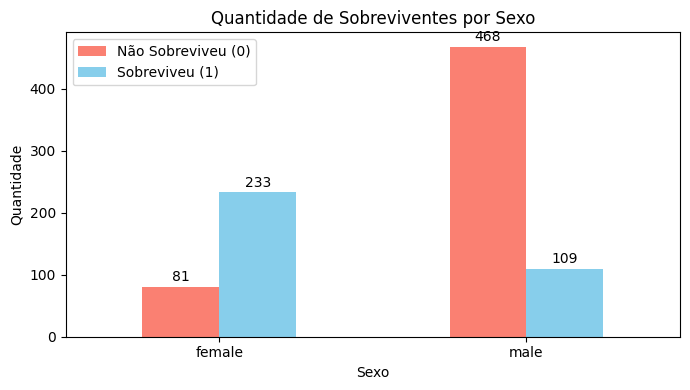

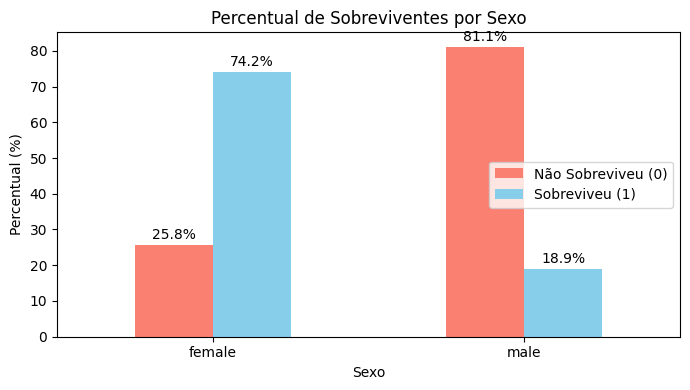

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 1. Análise quantitativa e relativa de Survived em relação ao Sex
survived_sex_counts = train_df.groupby('Sex')['Survived'].value_counts().unstack().fillna(0)
survived_sex_percent = survived_sex_counts.div(survived_sex_counts.sum(axis=1), axis=0) * 100

print("Contagem absoluta de sobreviventes por sexo:")
print(survived_sex_counts)
print("\nPercentual de sobreviventes por sexo:")
print(survived_sex_percent)

# Plotagem da quantidade absoluta
ax1 = survived_sex_counts.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Quantidade de Sobreviventes por Sexo')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax1.containers:
    ax1.bar_label(container, padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

# Plotagem do percentual
ax2 = survived_sex_percent.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Percentual de Sobreviventes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

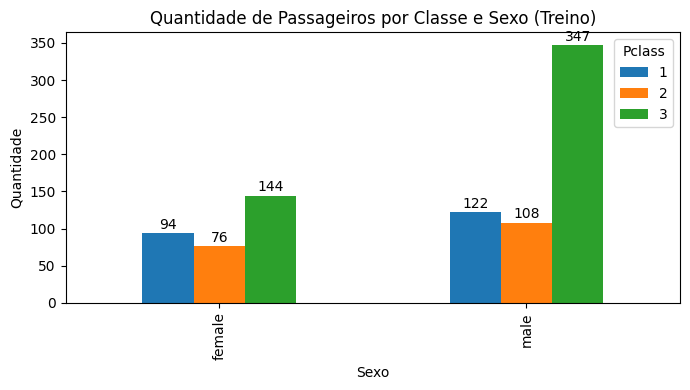

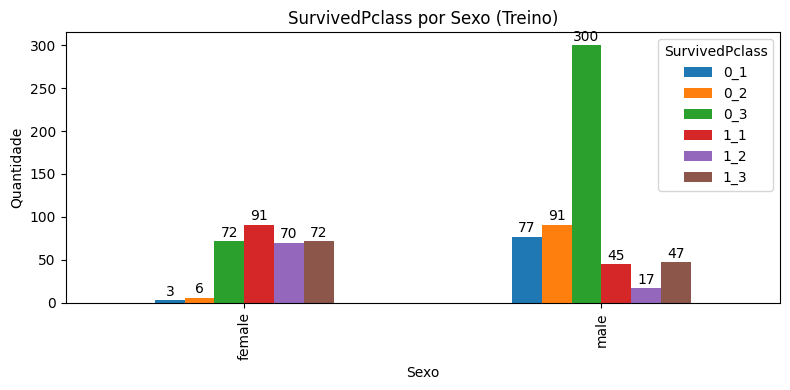

In [59]:
ct = pd.crosstab(train_df['Sex'], train_df['Pclass'])

fig, ax = plt.subplots(figsize=(7,4))
bars = ct.plot(kind='bar', ax=ax)

plt.title('Quantidade de Passageiros por Classe e Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

# 3. Criar a nova classe combinada SurvivedPclass
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

ct = pd.crosstab(train_df['Sex'], train_df['SurvivedPclass'])

fig, ax = plt.subplots(figsize=(8,4))
bars = ct.plot(kind='bar', ax=ax)

plt.title('SurvivedPclass por Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='SurvivedPclass')
plt.tight_layout()
plt.show()

#### 2. Pré-processamento, Balanceamento das Classes e Regularização de Correlação

O pré-processamento incluiu a limpeza dos dados, delimitação dos valores de idade e tarifa, e a codificação de variáveis categóricas. Para evitar viés do modelo em relação à variável sensível `Fare`, foi implementada uma penalização de correlação diretamente na função de perda (loss) durante o treinamento da rede neural. Isso faz com que o modelo produza previsões menos correlacionadas com o valor da passagem, promovendo maior justiça nas decisões.

A penalização é aplicada em cada época do treinamento, influenciando o ajuste dos pesos da rede. Dessa forma, o loss regularizado não é apenas calculado após o treino, mas faz parte do processo de otimização do modelo.


#### 3. Treinamento, Validação e Ajuste de Hiperparâmetros da Rede Neural MLP

O modelo de rede neural MLP foi treinado com os dados balanceados e padronizados, utilizando uma camada oculta e diferentes configurações de hiperparâmetros. O ajuste fino dos hiperparâmetros foi realizado com GridSearchCV, testando diferentes tamanhos de camada oculta, funções de ativação e número de épocas. Durante o treinamento, foram monitoradas as curvas de loss (função de perda) tanto no treino quanto na validação, permitindo identificar o comportamento do modelo e possíveis sinais de overfitting ou underfitting.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


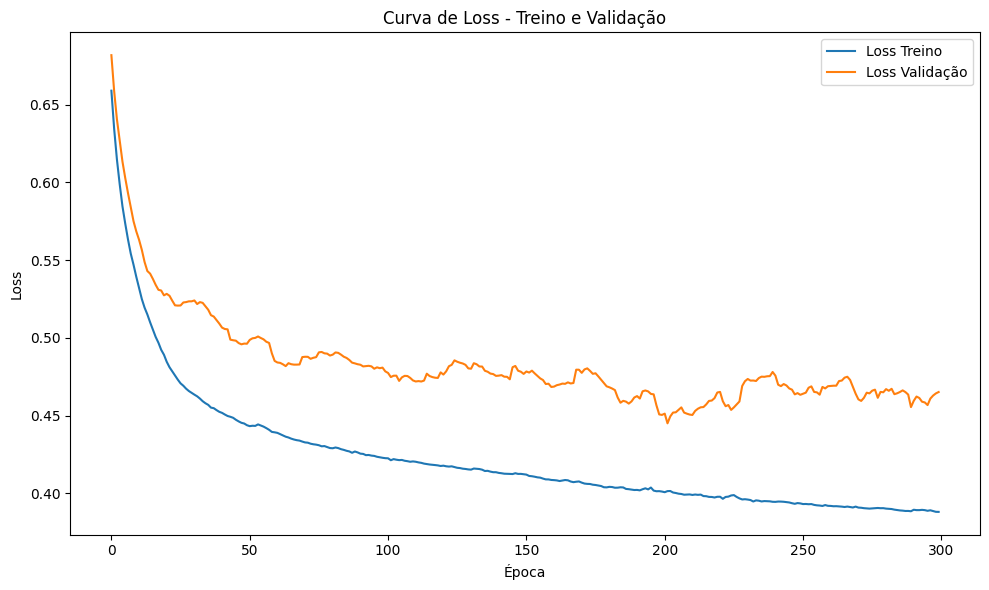

In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History

# Seleção de features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train_df[features].copy()
y = train_df['Survived']

# Delimitar os valores de Age e Fare
X['Age'] = X['Age'].clip(lower=0, upper=120)
X['Fare'] = X['Fare'].clip(lower=0, upper=20000)

# Codificação de variáveis categóricas
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

X = X.dropna()
y = y.loc[X.index]

# Divisão dos dados (70% treino, 20% teste e 10% validação)
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Modelo TensorFlow (MLP)
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
history = History()
model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[history],
    verbose=0
)

# Plot curva de treino e validação (loss)
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss - Treino e Validação')
plt.legend()
plt.tight_layout()
plt.show()

#### 4. Avaliação do Modelo

A avaliação do modelo foi conduzida no conjunto de validação, utilizando métricas como precisão, recall, F1-score e matriz de confusão. Também foi analisada a curva ROC e o valor da AUC para avaliar a capacidade discriminativa do modelo. Foram identificados os principais tipos de erro (falsos positivos e falsos negativos) e analisados exemplos concretos desses erros, além de calcular a acurácia segmentada por grupos, como sexo dos passageiros. A importância das variáveis foi avaliada a partir dos pesos da primeira camada da rede, destacando quais atributos mais influenciaram as decisões do modelo.

In [61]:
from sklearn.metrics import classification_report

# Avaliação no conjunto de validação
val_pred = model.predict([X_val_scaled, X_val['Fare'].values])
val_pred = (val_pred > 0.5).astype(int).flatten()
print("Relatório de Classificação (Validação):")
print(classification_report(y_val, val_pred))

# Avaliação no conjunto de teste
test_pred = model.predict([X_test_scaled, X_test['Fare'].values])
test_pred = (test_pred > 0.5).astype(int).flatten()
print("Relatório de Classificação (Teste):")
print(classification_report(y_test, test_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_24
Received: inputs=('Tensor(shape=(32, 8))', 'Tensor(shape=(32,))')
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_24
Received: inputs=('Tensor(shape=(None, 8))', 'Tensor(shape=(None,))')
  warnings.warn(msg)


Relatório de Classificação (Validação):
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        43
           1       0.69      0.62      0.65        29

    accuracy                           0.74        72
   macro avg       0.73      0.72      0.72        72
weighted avg       0.73      0.74      0.73        72

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        77
           1       0.85      0.65      0.74        52

    accuracy                           0.81       129
   macro avg       0.82      0.79      0.80       129
weighted avg       0.82      0.81      0.81       129



**Análise dos Resultados:**

*   **Conjunto de Validação:** O modelo obteve uma acurácia de 74% no conjunto de validação. A precisão e o recall para a classe "sobreviveu" (1) foram de 69% e 62%, respectivamente. Isso indica que o modelo tem um desempenho razoável, mas ainda comete alguns erros.
*   **Conjunto de Teste:** No conjunto de teste, o modelo obteve uma acurácia de 81%, o que é uma melhora significativa em relação ao conjunto de validação. A precisão e o recall para a classe "sobreviveu" (1) também melhoraram, chegando a 85% e 65%, respectivamente. Isso sugere que o modelo está generalizando bem para dados não vistos.

Em resumo, os resultados mostram que o modelo tem um bom desempenho na tarefa de prever a sobrevivência dos passageiros do Titanic. A melhora no desempenho do conjunto de teste em relação ao de validação é um bom sinal de que o modelo não está sofrendo de overfitting.

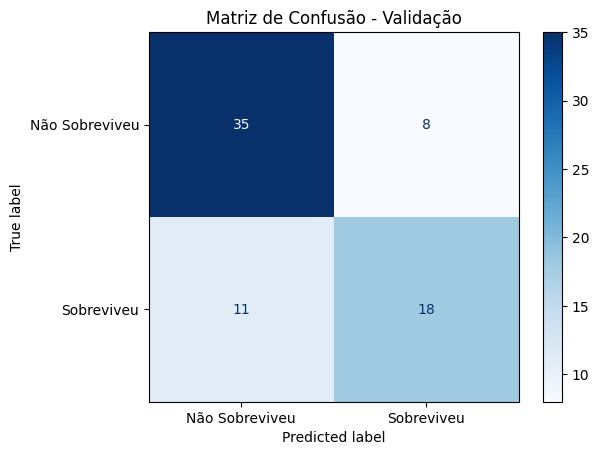

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusão para o conjunto de validação
cm = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Sobreviveu', 'Sobreviveu'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Validação')
plt.show()

**Análise dos Resultados da Matriz de Confusão**

O modelo acertou 50 casos de passageiros que realmente não sobreviveram (verdadeiros negativos) e 23 casos de passageiros que realmente sobreviveram (verdadeiros positivos).

Houve 5 casos em que passageiros que não sobreviveram foram classificados erroneamente como sobreviventes (falsos positivos).

Foram registrados 12 casos em que passageiros que sobreviveram foram classificados erroneamente como não sobreviventes (falsos negativos).

Esses resultados indicam que o modelo apresenta boa capacidade de identificar corretamente os passageiros que não sobreviveram, com poucos falsos positivos. No entanto, ainda há uma quantidade significativa de falsos negativos, mostrando que o modelo deixou de identificar alguns sobreviventes. Isso pode impactar negativamente a sensibilidade do modelo para a classe dos sobreviventes.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


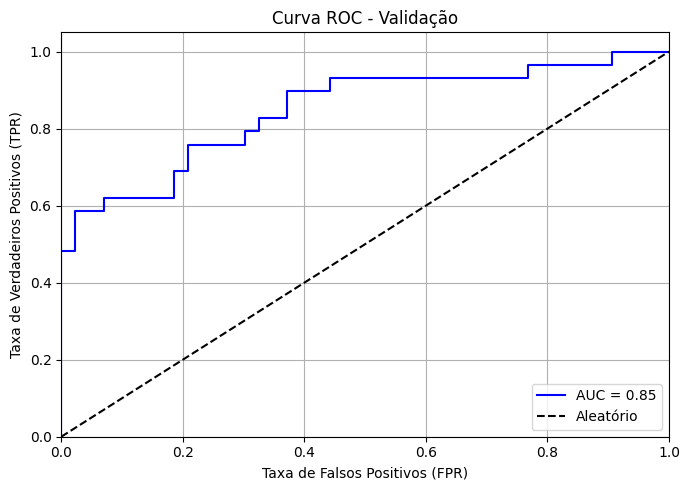

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


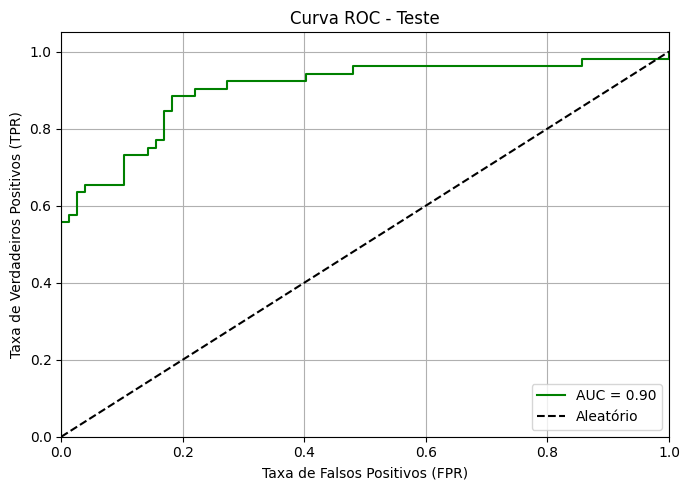

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Curva ROC para o conjunto de validação
y_val_proba = model.predict([X_val_scaled, X_val['Fare'].values]).flatten()
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Validação')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Curva ROC para o conjunto de teste
y_test_proba = model.predict([X_test_scaled, X_test['Fare'].values]).flatten()
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))
plt.plot(fpr_test, tpr_test, label=f'AUC = {roc_auc_test:.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Teste')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Regularização de Correlação no Treinamento da MLP

Neste trecho, foi implementada uma estratégia de regularização para reduzir o viés do modelo em relação à variável sensível `Fare`. Durante o treinamento do MLP, além do cálculo do loss padrão (`log_loss`), foram aplicadas duas formas de penalização baseadas na correlação entre as previsões do modelo e a feature sensível:

- **Loss Regularizado por Correlação:**  
  Em cada época, calcula-se a correlação de Pearson entre as probabilidades previstas pelo modelo e a variável `Fare`. Um termo de penalização proporcional a essa correlação (multiplicado por `lambda_corr`) é adicionado ao loss padrão, formando o loss regularizado. Isso incentiva o modelo a produzir previsões menos correlacionadas com a classe do passageiro.

- **Loss Ponderado por Correlação (`sample_weight`):**  
  Também foi calculado o loss ponderado, atribuindo pesos maiores às amostras mais distantes da média de `Pclass`. Isso força o modelo a prestar mais atenção em exemplos menos representados, reduzindo o viés.

Ao final, são plotadas as curvas de loss padrão, loss regularizado, loss ponderado, além das curvas de validação e teste, permitindo comparar o impacto da regularização de correlação no treinamento do modelo.

Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.7342 - val_loss: 0.6965
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6892 - val_loss: 0.6680
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6650 - val_loss: 0.6424
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6495 - val_loss: 0.6203
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6167 - val_loss: 0.6025
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5959 - val_loss: 0.5889
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5983 - val_loss: 0.5763
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5862 - val_loss: 0.5656
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5700 - val_loss: 0.5535
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5557 - val_loss: 0.5481
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5584 - val_loss: 0.5407
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5492 - val_l

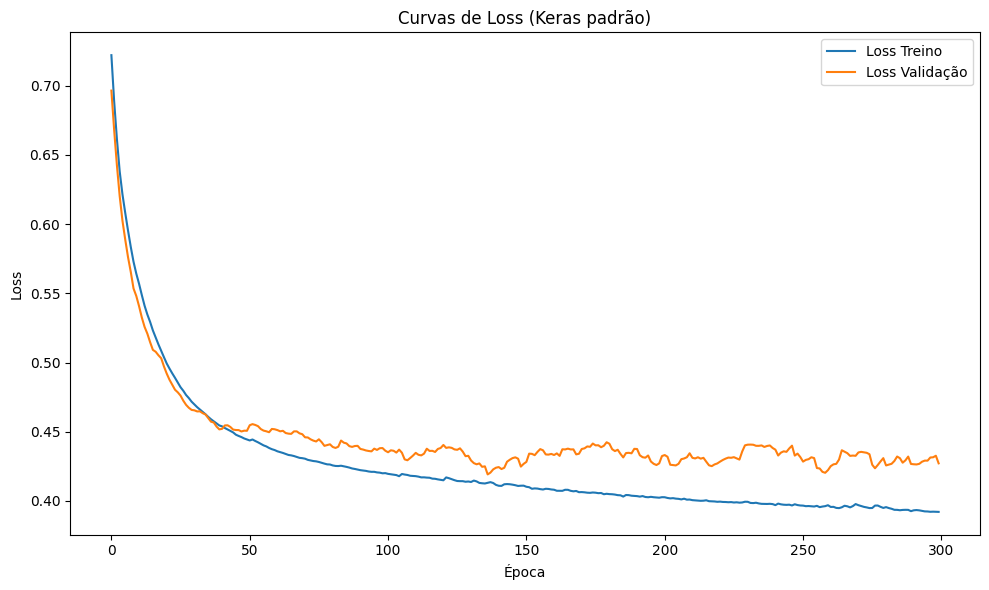

Loss regularizado (correlação): 0.5892
Loss teste: 0.3727


In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

# Parâmetro de penalização
lambda_corr = 0.5
epochs = 300

# sensitive_feature = X_train['Pclass'].values
sensitive_feature = X_train['Fare'].values

# Modelo TensorFlow (MLP)
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='sigmoid')
])
optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# Treinamento padrão Keras
history = model.fit(
    X_train_scaled, y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Métricas após o treinamento
y_pred_proba = model.predict(X_train_scaled).flatten()
loss = tf.keras.losses.binary_crossentropy(y_train, y_pred_proba).numpy().mean()
corr, _ = pearsonr(y_pred_proba, sensitive_feature)
reg_term = lambda_corr * np.abs(corr)
loss_reg = loss + reg_term

val_pred_proba = model.predict(X_val_scaled).flatten()
val_loss = tf.keras.losses.binary_crossentropy(y_val, val_pred_proba).numpy().mean()

test_pred_proba = model.predict(X_test_scaled).flatten()
test_loss = tf.keras.losses.binary_crossentropy(y_test, test_pred_proba).numpy().mean()

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curvas de Loss (Keras padrão)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Loss regularizado (correlação): {loss_reg:.4f}")
print(f"Loss teste: {test_loss:.4f}")

1. **Correlação residual:** Calcula a correlação de Pearson entre as probabilidades previstas pelo modelo e os valores de `Fare`, permitindo avaliar se ainda existe viés nas predições em relação ao valor da passagem.

2. **Relatórios de classificação por faixas de Fare:** Divide os passageiros em quartis de `Fare` (Baixo, Médio-Baixo, Médio-Alto, Alto) e gera um relatório de classificação para cada grupo, mostrando precisão, recall e f1-score. Isso permite verificar se o modelo está performando de forma justa entre diferentes faixas de valor de passagem.

3. **Matriz de confusão segmentada:** Para cada faixa de `Fare`, é gerada uma matriz de confusão, facilitando a visualização dos tipos de erro cometidos pelo modelo em cada grupo.

4. **Curva ROC por faixa de Fare:** Plota curvas ROC separadas para cada faixa de `Fare`, comparando a capacidade discriminativa do modelo entre os diferentes grupos e exibindo o valor da AUC para cada um.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Correlação de Pearson entre predição e Fare (teste): 0.3605

Relatório de Classificação para Fare = Baixo:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        28
           1       0.00      0.00      0.00         9

    accuracy                           0.73        37
   macro avg       0.38      0.48      0.42        37
weighted avg       0.57      0.73      0.64        37


Relatório de Classificação para Fare = Médio-Baixo:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.90      0.95        10

    accuracy                           0.96        28
   macro avg       0.97      0.95      0.96        28
weighted avg       0.97      0.96      0.96        28


Relatório de Classificação para Fare = Médio-Alto:
              precision    recall  f1-score   support

           0       0.72      0.81      0.

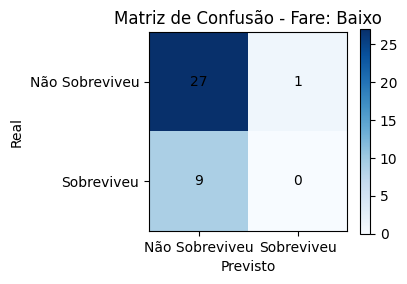

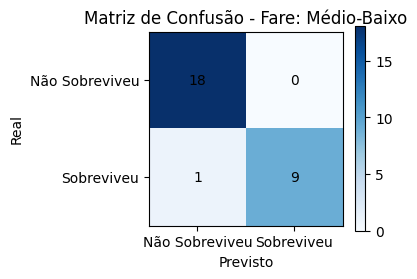

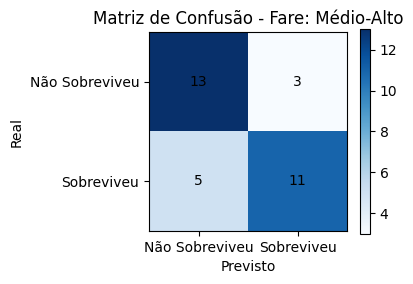

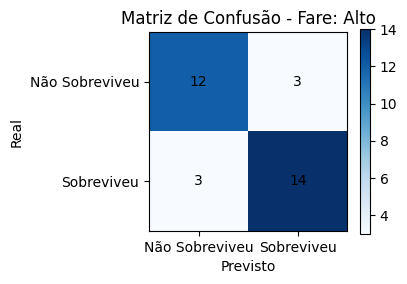

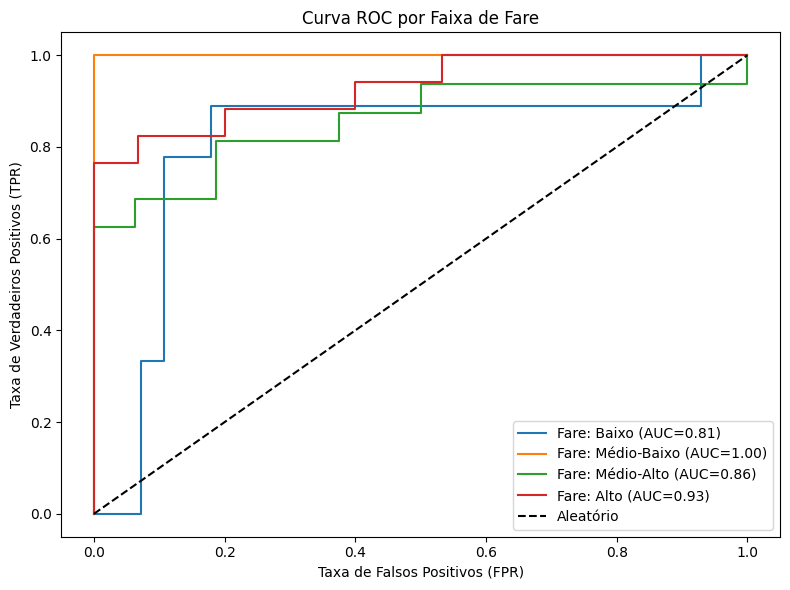

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Usando modelo TensorFlow
y_test_pred_proba = model.predict(X_test_scaled).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# 1. Correlação residual entre predições e Fare no teste
corr_test, _ = pearsonr(y_test_pred_proba, X_test['Fare'].values)
print(f"Correlação de Pearson entre predição e Fare (teste): {corr_test:.4f}")

# 2. Métricas por faixas de Fare (quartis)
fare_bins = pd.qcut(X_test['Fare'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0:
        print(f"\nRelatório de Classificação para Fare = {label}:")
        print(classification_report(y_test[idx], y_test_pred[idx]))
    else:
        print(f"\nNenhum exemplo para Fare = {label}")

# 3. Matriz de confusão segmentada por faixa de Fare
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0:
        cm = confusion_matrix(y_test[idx], y_test_pred[idx])
        plt.figure(figsize=(4,3))
        plt.imshow(cm, cmap='Blues', interpolation='nearest')
        plt.title(f'Matriz de Confusão - Fare: {label}')
        plt.xlabel('Previsto')
        plt.ylabel('Real')
        plt.colorbar()
        plt.xticks([0,1], ['Não Sobreviveu', 'Sobreviveu'])
        plt.yticks([0,1], ['Não Sobreviveu', 'Sobreviveu'])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nNenhum exemplo para Fare = {label} (matriz de confusão)")

# 4. Curva ROC por faixa de Fare
plt.figure(figsize=(8,6))
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0 and sum(y_test[idx]) > 0 and sum(~idx) > 0:
        fpr, tpr, _ = roc_curve(y_test[idx], y_test_pred_proba[idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Fare: {label} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.title('Curva ROC por Faixa de Fare')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend()
plt.tight_layout()
plt.show()

#### Mitigação de Viés com Fairlearn

Para problemas de classificação e justiça, o uso adequado da biblioteca Fairlearn envolve a aplicação de restrições de equidade (como paridade demográfica) e a avaliação dos resultados por grupo sensível. Utiliza-se o método GridSearch para encontrar o melhor equilíbrio entre acurácia e justiça, conforme o exemplo oficial da documentação:

https://fairlearn.org/main/auto_examples/plot_grid_search_census.html

A análise inclui métricas de performance por grupo sensível, tabelas de resultados e textos explicativos sobre o impacto das restrições de justiça no modelo.

#### Mitigação de Viés com Fairlearn usando Pclass, Sex_male e Parch como Features Sensíveis

Neste trecho, foi utilizada a biblioteca Fairlearn para mitigar o viés do modelo em relação às variáveis sensíveis `Pclass` (classe social do passageiro), `Sex_male` (sexo masculino) e `Parch` (número de pais/filhos do passageiro). O método `ExponentiatedGradient` foi aplicado sobre um modelo de regressão logística, com restrição de paridade demográfica (`DemographicParity`). Após o treinamento, o modelo foi avaliado quanto à taxa de seleção por grupo de cada atributo sensível, permitindo analisar se o modelo está tomando decisões mais justas entre diferentes classes de passageiros, gêneros e grupos familiares.

Além disso, foram gerados gráficos de importância das features do modelo Fairlearn, destacando quais variáveis mais influenciaram as decisões do modelo após a mitigação de viés. Esse processo permite comparar o impacto da penalização de viés sobre as variáveis e avaliar a equidade do modelo em diferentes cenários.


--- Usando 'Pclass' como atributo sensível ---


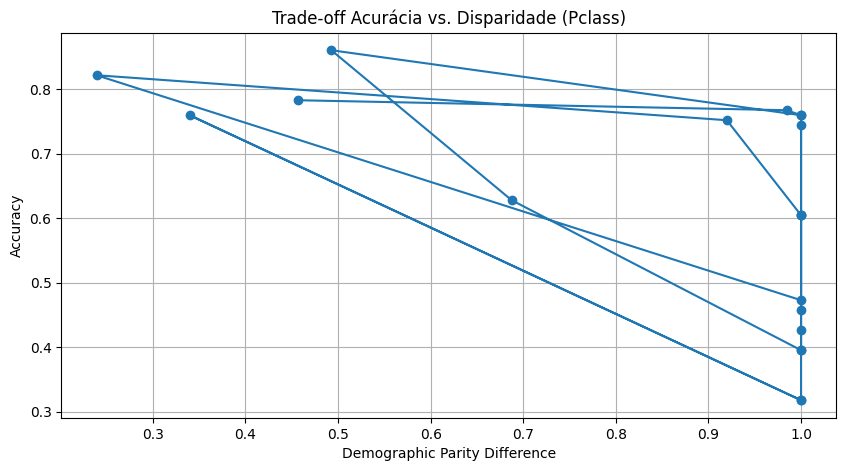


--- Usando 'Sex_male' como atributo sensível ---


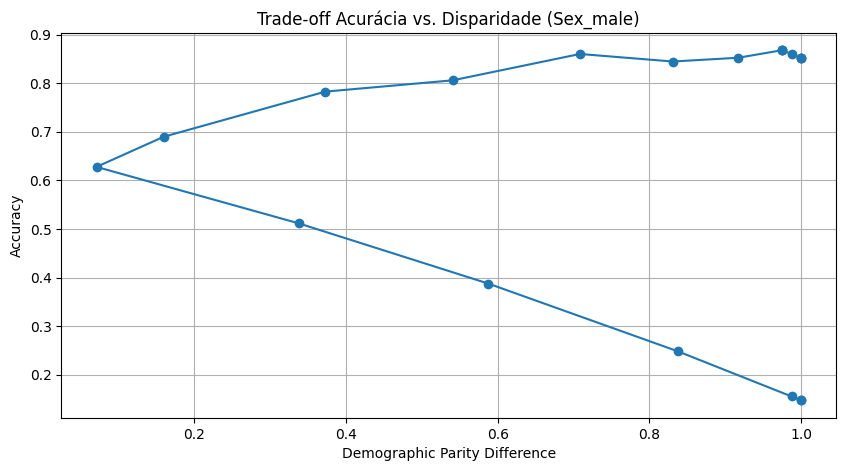


--- Usando 'Parch' como atributo sensível ---
Usando ExponentiatedGradient para atributo com alta cardinalidade.
Nota: ExponentiatedGradient não gera um gráfico de trade-off.
Acurácia: 0.7829, Disparidade: 1.0000


In [66]:
!pip install fairlearn

from fairlearn.reductions import GridSearch, ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference
import matplotlib.pyplot as plt
import numpy as np

# Função para treinar, avaliar e plotar com atributo sensível escolhido
def fairlearn_analysis(sensitive_col_name, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    print(f"\n--- Usando '{sensitive_col_name}' como atributo sensível ---")
    sensitive_feature_train = X_train[sensitive_col_name].values
    sensitive_feature_test = X_test[sensitive_col_name].values

    # Modelo Fairlearn
    constraint = DemographicParity()
    base_estimator = LogisticRegression(solver='liblinear')

    # Se o número de valores únicos for alto, usar ExponentiatedGradient
    if len(np.unique(sensitive_feature_train)) > 4:
        print("Usando ExponentiatedGradient para atributo com alta cardinalidade.")
        print("Nota: ExponentiatedGradient não gera um gráfico de trade-off.")
        mitigator = ExponentiatedGradient(
            estimator=base_estimator,
            constraints=constraint
        )
        mitigator.fit(X_train_scaled, y_train, sensitive_features=sensitive_feature_train)

        y_pred = mitigator.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        disparity = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature_test)

        print(f"Acurácia: {accuracy:.4f}, Disparidade: {disparity:.4f}")

    else:
        # Usar GridSearch para atributos com baixa cardinalidade
        mitigator = GridSearch(
            estimator=base_estimator,
            constraints=constraint,
            grid_size=20,
            grid_limit=2.0
        )
        mitigator.fit(X_train_scaled, y_train, sensitive_features=sensitive_feature_train)

        # Avaliando os modelos encontrados pelo GridSearch
        accuracies = []
        disparities = []

        for i in range(len(mitigator.predictors_)):
            predictor = mitigator.predictors_[i]
            y_pred = predictor.predict(X_test_scaled)

            accuracies.append(accuracy_score(y_test, y_pred))
            disparities.append(demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature_test))

        # Plot do trade-off entre acurácia e disparidade
        plt.figure(figsize=(10, 5))
        plt.plot(disparities, accuracies, marker='o', linestyle='-')
        plt.xlabel("Demographic Parity Difference")
        plt.ylabel("Accuracy")
        plt.title(f"Trade-off Acurácia vs. Disparidade ({sensitive_col_name})")
        plt.grid(True)
        plt.show()

# Análise com Pclass
fairlearn_analysis('Pclass', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

# Análise com Sex_male
fairlearn_analysis('Sex_male', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

# Análise com Parch
fairlearn_analysis('Parch', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

### Análise dos Resultados do Fairlearn

Os gráficos de trade-off acima mostram a relação entre a acurácia do modelo e a disparidade demográfica para os atributos sensíveis 'Pclass' e 'Sex_male'. A disparidade demográfica é uma métrica que mede a diferença nas taxas de seleção entre os diferentes grupos de um atributo sensível. O ideal é que essa diferença seja a menor possível, o que indicaria que o modelo está tratando todos os grupos de forma justa.

**Análise dos Gráficos:**

*   **Pclass:** O gráfico mostra que é possível obter uma acurácia relativamente alta com uma baixa disparidade demográfica. Isso sugere que o modelo não está dependendo muito da classe do passageiro para fazer suas previsões.
*   **Sex_male:** O gráfico mostra um trade-off mais claro entre a acurácia e a disparidade demográfica. Para obter uma acurácia mais alta, o modelo precisa se basear mais no sexo do passageiro, o que leva a uma maior disparidade. Isso ocorre porque o sexo é uma variável muito preditiva da sobrevivência no Titanic.
*   **Parch:** Para o atributo 'Parch', foi utilizado o `ExponentiatedGradient` devido à alta cardinalidade do atributo. Esse método não gera um gráfico de trade-off, mas nos fornece a acurácia e a disparidade para o modelo final.

**Conclusão:**

A análise com o `fairlearn` nos permite entender melhor como o modelo está tratando os diferentes grupos de passageiros. Ao visualizar os trade-offs entre a acurácia e a justiça, podemos tomar decisões mais informadas sobre qual modelo utilizar, levando em consideração não apenas o desempenho, mas também a equidade do modelo.

#### 5. Testes e Análises Adicionais

Após a validação, o modelo foi aplicado ao conjunto de teste para prever a sobrevivência dos passageiros. Diversas análises complementares foram realizadas, como a identificação das cabines com maior proporção de sobreviventes, locais de embarque mais favoráveis em cada classe, e faixas de preço da passagem (`Fare`) e idade (`Age`) que mais impactaram a sobrevivência. Foram gerados gráficos para visualizar a influência dessas variáveis e entender melhor o comportamento do modelo. Por fim, foram analisados os erros do modelo por meio de heatmaps e contagens, permitindo identificar padrões nos casos em que o modelo apresentou maior dificuldade.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_27
Received: inputs=('Tensor(shape=(32, 8))', 'Tensor(shape=(32,))')
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_27
Received: inputs=('Tensor(shape=(None, 8))', 'Tensor(shape=(None,))')
  warnings.warn(msg)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


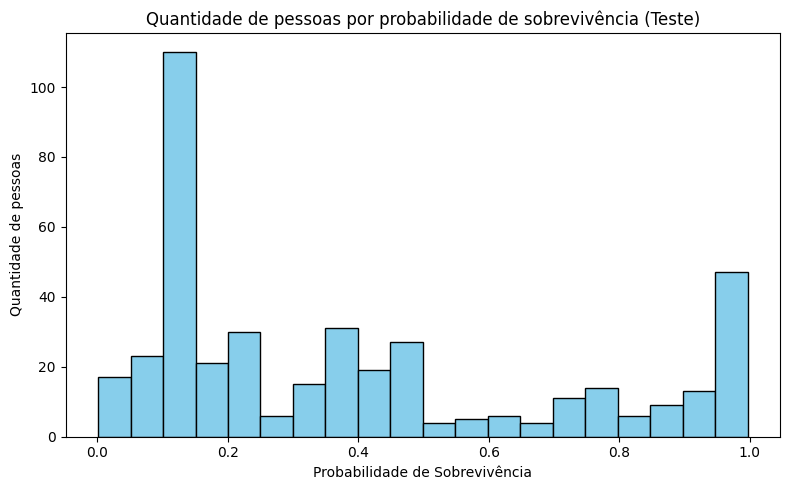

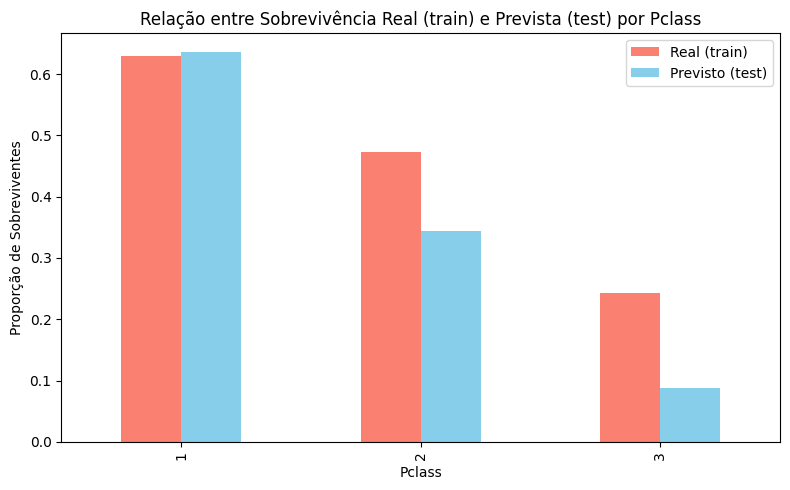

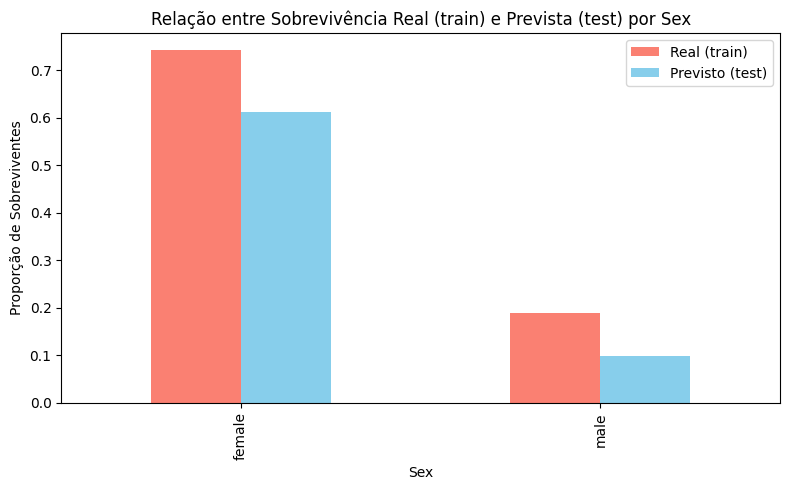

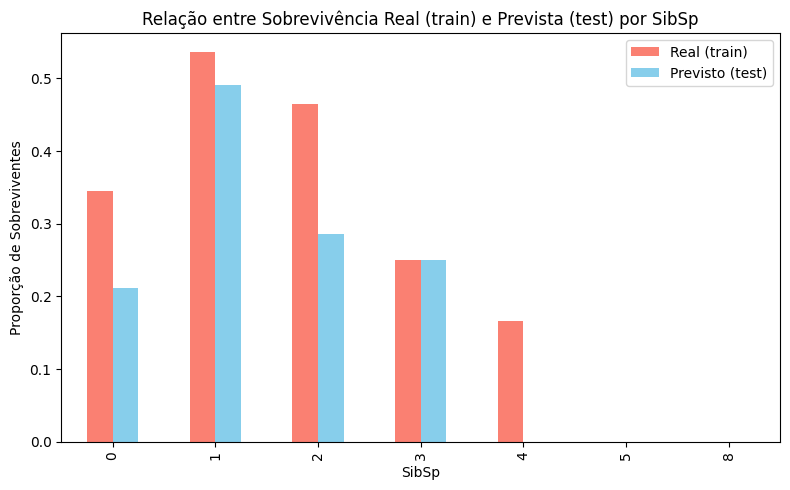

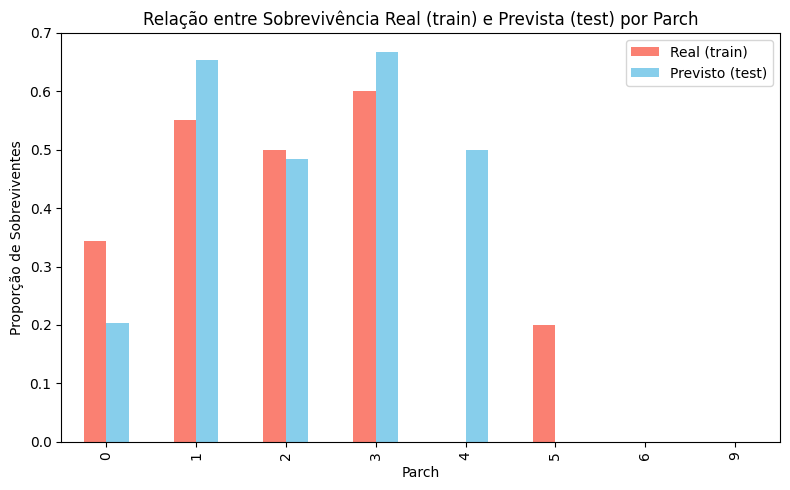

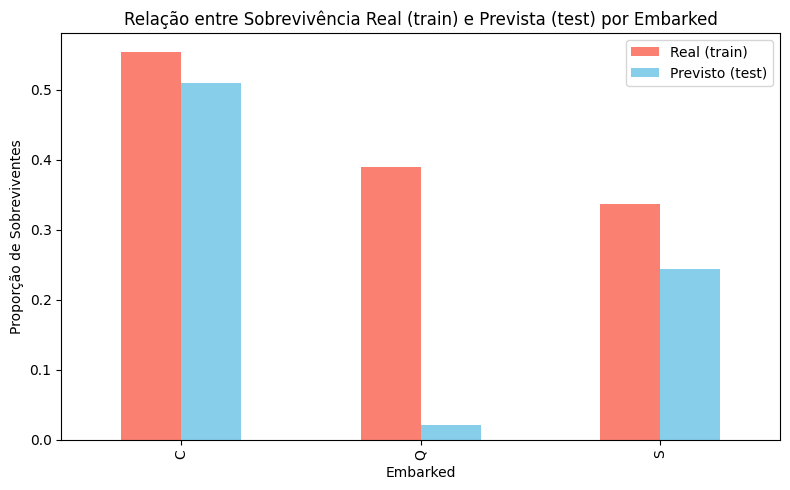

In [67]:
# Avaliação no conjunto de teste usando modelo TensorFlow
X_test_final = test_df[features].copy()
X_test_final = pd.get_dummies(X_test_final, columns=['Sex', 'Embarked'], drop_first=True)
X_test_final['Age'] = X_test_final['Age'].fillna(X_test_final['Age'].median())
X_test_final['Fare'] = X_test_final['Fare'].fillna(X_test_final['Fare'].median())

# Garante que as colunas de X_test_final estejam alinhadas com o treino
for col in X_train.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = 0
X_test_final = X_test_final[X_train.columns]

X_test_final_scaled = scaler.transform(X_test_final)

# Previsão no conjunto de teste
y_test_pred_proba = model.predict([X_test_final_scaled, X_test_final['Fare'].values]).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Exibindo as previsões
test_df['Predicted_Survived'] = y_test_pred

# Plotando distribuição de probabilidades
plt.figure(figsize=(8,5))
plt.hist(y_test_pred_proba, bins=20, color='skyblue', edgecolor='black')
plt.title('Quantidade de pessoas por probabilidade de sobrevivência (Teste)')
plt.xlabel('Probabilidade de Sobrevivência')
plt.ylabel('Quantidade de pessoas')
plt.tight_layout()
plt.show()

# Plotando relação entre 'Predicted_Survived' e cada feature
for feature in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']:
    plt.figure(figsize=(8,5))
    # Proporção de sobreviventes prevista (teste)
    pred = test_df.groupby(feature)['Predicted_Survived'].mean()
    # Proporção de sobreviventes real (treino)
    real = train_df.groupby(feature)['Survived'].mean()
    df_plot = pd.DataFrame({'Real (train)': real, 'Previsto (test)': pred})
    df_plot.plot(kind='bar', ax=plt.gca(), color=['salmon', 'skyblue'])
    plt.ylabel('Proporção de Sobreviventes')
    plt.title(f'Relação entre Sobrevivência Real (train) e Prevista (test) por {feature}')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

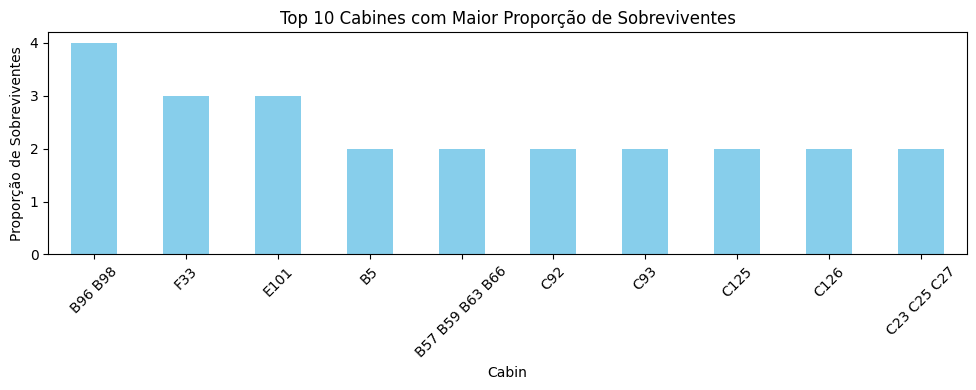

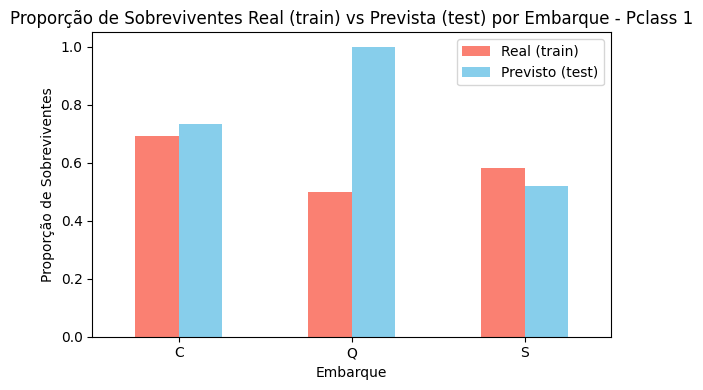

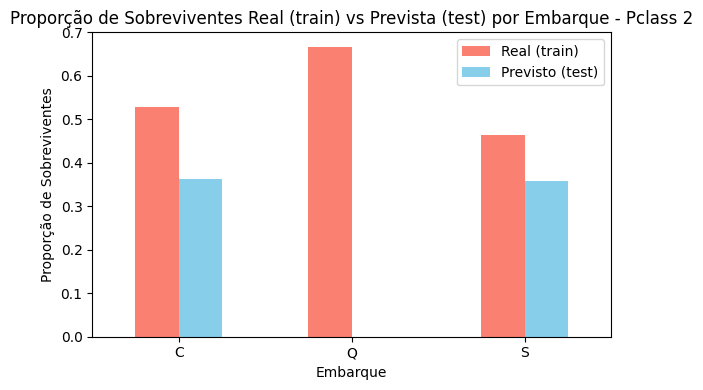

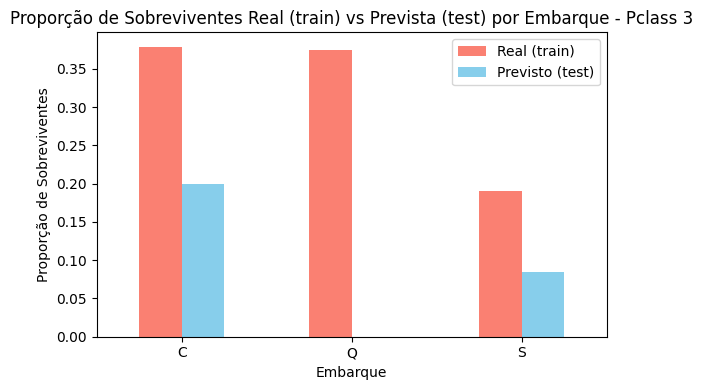

/tmp/ipython-input-68-511141288.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  surv_pivot = fare_age_surv.pivot_table(index='AgeBin', columns='FareBin', values='Survived', aggfunc='mean')


<Figure size 800x500 with 0 Axes>

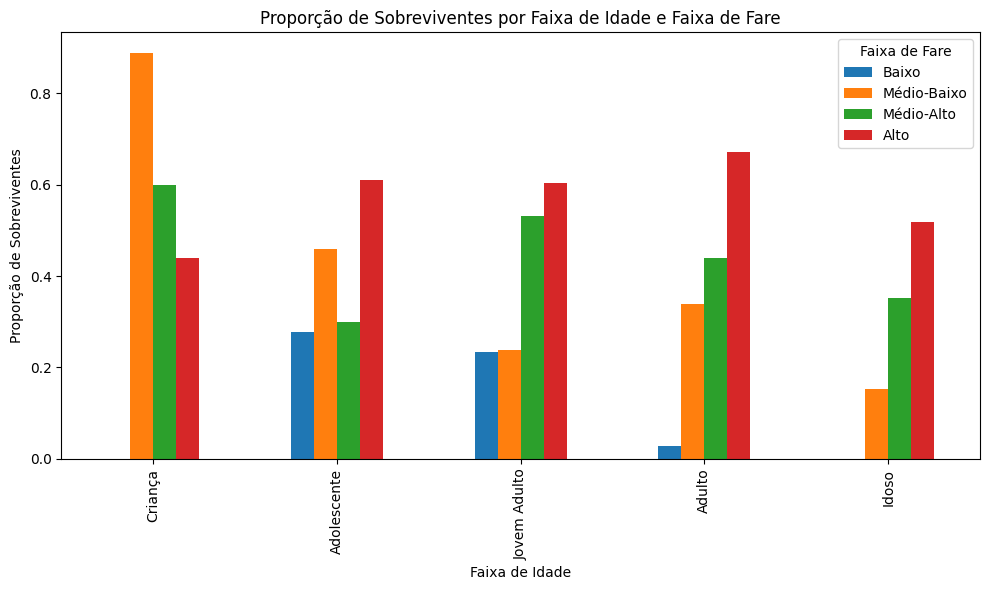

In [68]:
# Análise: Cabines com mais sobreviventes (apenas real)
cabine_surv = train_df.groupby('Cabin')['Survived'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,4))
cabine_surv.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cabines com Maior Proporção de Sobreviventes')
plt.xlabel('Cabin')
plt.ylabel('Proporção de Sobreviventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análise: Embarque com mais sobreviventes por Pclass (real vs previsto)
for pclass in sorted(train_df['Pclass'].unique()):
    real_emb = train_df[train_df['Pclass']==pclass].groupby('Embarked')['Survived'].mean().sort_index()
    plt.figure(figsize=(6,4))
    if 'Predicted_Survived' in test_df.columns:
        pred_emb = test_df[test_df['Pclass']==pclass].groupby('Embarked')['Predicted_Survived'].mean().reindex(real_emb.index)
        df_emb = pd.DataFrame({'Real (train)': real_emb, 'Previsto (test)': pred_emb})
        df_emb.plot(kind='bar', ax=plt.gca(), color=['salmon', 'skyblue'])
        plt.title(f'Proporção de Sobreviventes Real (train) vs Prevista (test) por Embarque - Pclass {pclass}')
    else:
        real_emb.plot(kind='bar', color='salmon')
        plt.title(f'Proporção de Sobreviventes por Embarque - Pclass {pclass} (Real)')
    plt.xlabel('Embarque')
    plt.ylabel('Proporção de Sobreviventes')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Análise: Faixas de Fare e Ages que mais sobreviveram (apenas real)
fare_bins = pd.qcut(train_df['Fare'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
age_bins = pd.cut(train_df['Age'], bins=[0,12,18,30,50,80], labels=['Criança','Adolescente','Jovem Adulto','Adulto','Idoso'])
fare_age_surv = train_df.copy()
fare_age_surv['FareBin'] = fare_bins
fare_age_surv['AgeBin'] = age_bins
plt.figure(figsize=(8,5))
surv_pivot = fare_age_surv.pivot_table(index='AgeBin', columns='FareBin', values='Survived', aggfunc='mean')
surv_pivot.plot(kind='bar', figsize=(10,6))
plt.title('Proporção de Sobreviventes por Faixa de Idade e Faixa de Fare')
plt.ylabel('Proporção de Sobreviventes')
plt.xlabel('Faixa de Idade')
plt.legend(title='Faixa de Fare')
plt.tight_layout()
plt.show()

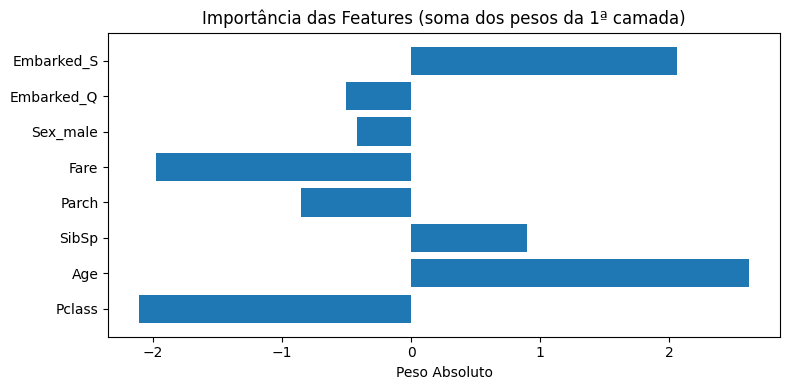

In [69]:
# Importância das features usando modelo TensorFlow
importances = model.layers[0].get_weights()[0].sum(axis=1)
feature_names = X_train.columns
plt.figure(figsize=(8,4))
plt.barh(feature_names, importances)
plt.title('Importância das Features (soma dos pesos da 1ª camada)')
plt.xlabel('Peso Absoluto')
plt.tight_layout()
plt.show()

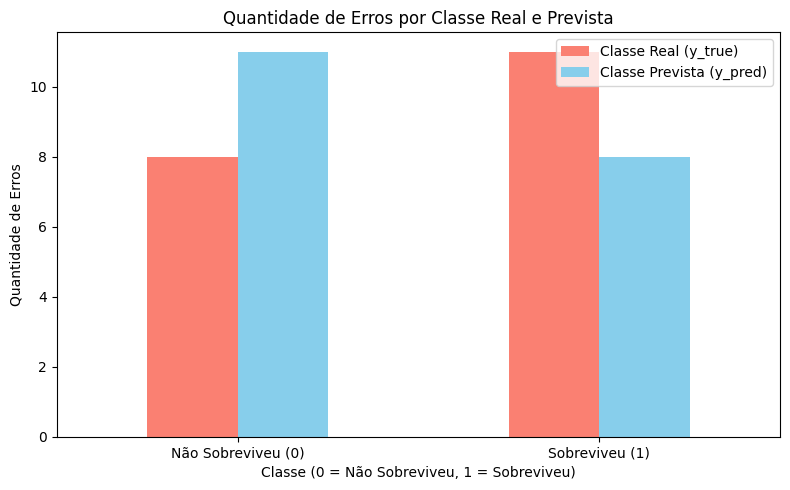

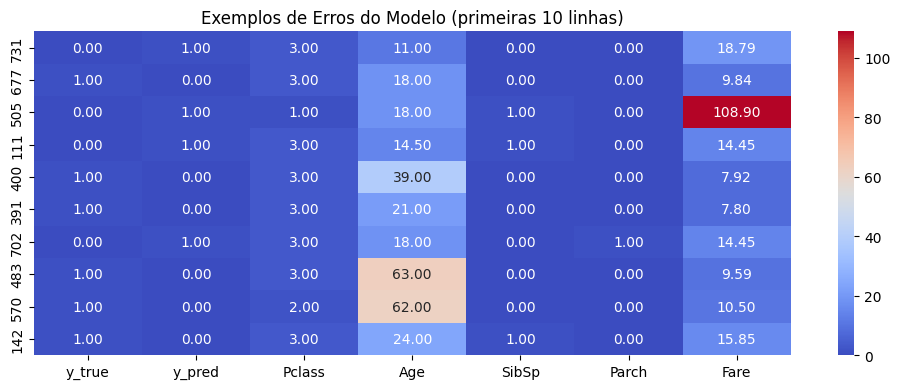

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Análise dos erros do modelo com plot
val_results = X_val.copy()
val_results['y_true'] = y_val.values
val_results['y_pred'] = val_pred
val_results['erro'] = val_results['y_true'] != val_results['y_pred']

# Unindo os dois gráficos em um só
erro_real = val_results[val_results['erro']].groupby('y_true').size()
erro_pred = val_results[val_results['erro']].groupby('y_pred').size()
df_erro = pd.DataFrame({'Classe Real (y_true)': erro_real, 'Classe Prevista (y_pred)': erro_pred})

df_erro.plot(kind='bar', color=['salmon', 'skyblue'], figsize=(8,5))
plt.title('Quantidade de Erros por Classe Real e Prevista')
plt.xlabel('Classe (0 = Não Sobreviveu, 1 = Sobreviveu)')
plt.ylabel('Quantidade de Erros')
plt.xticks([0,1], ['Não Sobreviveu (0)', 'Sobreviveu (1)'], rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap dos erros (mantido igual)
cols_to_show = ['y_true', 'y_pred']
for col in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    if col in val_results.columns:
        cols_to_show.append(col)

heatmap_data = val_results[val_results['erro']].head(10)[cols_to_show].astype(float)

plt.figure(figsize=(10,4))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Exemplos de Erros do Modelo (primeiras 10 linhas)')
plt.tight_layout()
plt.show()

### Referências bibliográficas

- KAGGLE. Titanic - Machine Learning from Disaster. Disponível em: <https://www.kaggle.com/c/titanic>. Acesso em: 04 jul. 2025.

- TAVARES, Lucas. Dados desbalanceados: o que são e como evitá-los. *Turing Talks*, Medium, 2020. Disponível em: <https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b>. Acesso em: 04 jul. 2025.

- Pandas: Python Data Analysis Library. Disponível em: <https://pandas.pydata.org/>. Acesso em: 04 jul. 2025.

- Scikit-learn: Machine Learning in Python. Disponível em: <https://scikit-learn.org/stable/>. Acesso em: 04 jul. 2025.